# Introduction to Spatial Data Science and Machine Learning

### Overview
Welcome to the Introduction to Spatial Data Science and Machine Learning workshop for UCL's Urban Design B-Pro programme 2022/2023.

These workshops will provide a broad introduction to spatial data science with Python.

## 03. Machine Learning
This workshop provides an intro to machine learning for spatial data science utilising Python. It will cover some of the basics of machine learning including spatial regression and spatial clustering (e.g. k-means clustering) in Python.

In [8]:
import numpy as np
import seaborn as sns
import pandas
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import libpysal
from libpysal.weights import Queen
from libpysal  import weights
import splot
from splot.libpysal import plot_spatial_weights
import pysal
from pysal.model import spreg
from spreg import OLS
import esda
from esda.moran import Moran
import sklearn
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import robust_scale
from sklearn.metrics import mean_squared_error as mse
import geemap
import ee
%matplotlib inline

### Supervised Machine Learning
In supervised machine learning, labelled datasets are utilised to train algorithms. This example will be draw on spatial and non-spatial [regression](https://en.wikipedia.org/wiki/Regression_analysis), an example of supervised machine learning.

The data is sourced from the 2019 Indices of Multiple Deprivation (IMD) dataset on the [London Datastore](https://data.london.gov.uk/dataset/indices-of-deprivation). The dataset contains deprivation scores for Greater London boroughs. Deprivation is measured across a range of socio-economic and environmental variables in the IMD dataset. This workshop focuses on the IMD, living environment and health deprivation and disability average scores. To summarise, the higher the average score, the more deprived the borough.

First, let's explore the IMD data.

In [9]:
# Load the IMD 2019 dataset
imd_2019 = gpd.read_file("https://github.com/lbuk/UD_Intro_SDSML2022/blob/master/03_machine_learning/data/gl_boro_imd_2019.geojson?raw=true")

In [10]:
# Print the dataset info
imd_2019.info

<bound method DataFrame.info of          code         local_authority  imd_avg_score  living_env_avg_score  \
0   E09000001          City of London           14.7                  39.0   
1   E09000002    Barking and Dagenham           32.8                  29.1   
2   E09000003                  Barnet           16.1                  24.7   
3   E09000004                  Bexley           16.3                  19.8   
4   E09000005                   Brent           25.6                  28.7   
5   E09000006                 Bromley           14.2                  18.4   
6   E09000007                  Camden           20.1                  33.5   
7   E09000008                 Croydon           22.5                  26.0   
8   E09000009                  Ealing           22.7                  30.3   
9   E09000010                 Enfield           25.8                  27.5   
10  E09000011               Greenwich           24.5                  24.6   
11  E09000012                 Ha

In [11]:
# Print the CRS
imd_2019.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

#### Baseline (Non-Spatial) Regression
We can express the baseline [Ordinary Least Squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) regression equation as:

$$
ln(Y_i) = \alpha + \beta{X_i} + \epsilon_i
$$

in which $Y_i$ is the dependent variable (i.e. logarithmic IMD average score), $X_i$ is the independent variable (i.e. the living environment average score), $\beta$ is the coefficient, or the amount the dependent variable changes for a unit increase in the independent variable, $\alpha$ is the intercept or the expected mean value of $ln(Y_i)$ when $X_i$ equals zero and $\epsilon_i$ is the "error" that specifies elements that influence the dependent variable but are not in $X_i$.

In [12]:
# Specify the dependent variable, which is logged. Logging the dependent variable is a way of normalising a skewed variable
imd_2019['log_imd_avg_score'] = np.log(imd_2019['imd_avg_score']) # Produce a new variable containing the logarithmic IMD average score
y = imd_2019['log_imd_avg_score'].values
y_n = 'log_imd_score'

In [13]:
# Specify the independent variable
x = np.array([imd_2019.living_env_avg_score]).T
x_n = 'living_env_score'

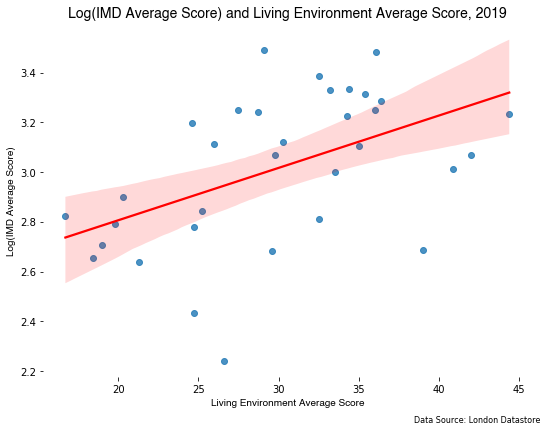

In [14]:
# Produce a scatterplot with IMD average score along the y-axis and living environment average score along the x-axis
fig = plt.figure(figsize=(8.75, 6.5))
ax = sns.regplot(x=x, # x-axis variable
                 y=y, # y-axis variable
                 data=imd_2019, # Data
                 line_kws=dict(color="red")) # Regression line

font_axes = {'family':'helvetica','color':'black','size':10} # Axes font
plt.xlabel('Living Environment Average Score',  fontdict = font_axes) # x-axis label
plt.ylabel('Log(IMD Average Score)',  fontdict = font_axes) # y-axis label

font_title = {'family':'helvetica','color':'black','size':14} # Font title
plt.title('Log(IMD Average Score) and Living Environment Average Score, 2019', fontdict=font_title)  # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (370.75,-45.85), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotation of data source

ax.set(frame_on=False) # Delete frame

plt.show()

In [15]:
# Create a spatial weights matrix, which connects nearby polygons
W = weights.KNN.from_dataframe(imd_2019, k=6)
W.transform = 'r'

(<Figure size 720x720 with 1 Axes>, <AxesSubplot: >)

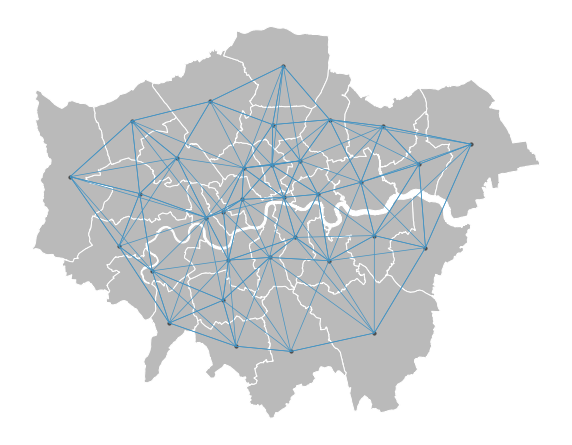

In [16]:
# Visualise the spatial weights matrix
plot_spatial_weights(W, imd_2019)

In [17]:
# Build the non-spatial OLS model
ols = OLS(y=y, # Dependent variable
          x=x, # Independent variable
          w=W, # Spatial weights matrix
          name_y=y_n, # Name of dependent variable
          name_x=[x_n], # Name of independent variable
          name_w="W", # Name of spatial weights matrix
          name_ds='imd_2019', # Dataset
          white_test=True, # White’s specification robust test
          spat_diag=True, # Lagrange multiplier tests
          moran=True) # Moran’s I on the residuals

print(ols.summary) # Print a summary of the OLS model

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    imd_2019
Weights matrix      :           W
Dependent Variable  :log_imd_score                Number of Observations:          33
Mean dependent var  :      3.0152                Number of Variables   :           2
S.D. dependent var  :      0.3071                Degrees of Freedom    :          31
R-squared           :      0.2410
Adjusted R-squared  :      0.2165
Sum squared residual:       2.291                F-statistic           :      9.8440
Sigma-square        :       0.074                Prob(F-statistic)     :    0.003721
S.E. of regression  :       0.272                Log likelihood        :      -2.809
Sigma-square ML     :       0.069                Akaike info criterion :       9.618
S.E of regression ML:      0.2635                Schwarz criterion     :      12.611

----------------------------------------------------------------------------

This summary of the non-spatial baseline regression model contains a number of key insights. Here, we will derive the coefficient, standard error and p-value from this regression model. 

The coefficient is the amount by which change in the independent must be multiplied to give the corresponding average change in the dependent variable, or the amount the dependent variable changes for a unit increase in the independent variable. 

The standard error represents the average distance that the values fall from the regression line. 

The p-value tests the null hypothesis that the coefficient is equal to zero and is a statistical measure of the extent to which the independent variable effects the dependent variable.

In [18]:
# Produce a dataset containing the coefficient, standard error and p-value from the OLS model
ols_vals = pandas.DataFrame({"Coefficient": ols.betas.flatten(), # Coefficient
                             "Standard Error": ols.std_err.flatten(), # Standard error
                             "P-Value": [i[1] for i in ols.t_stat], # P-Value
                            },index=ols.name_x) # Index of independent variables

print(ols_vals) # Print

                  Coefficient  Standard Error       P-Value
CONSTANT             2.385372        0.206240  8.900698e-13
living_env_score     0.021039        0.006705  3.720654e-03


In [19]:
# Derive the residual values by borough from the non-spatial baseline OLS model
imd_2019["residual"] = ols.u

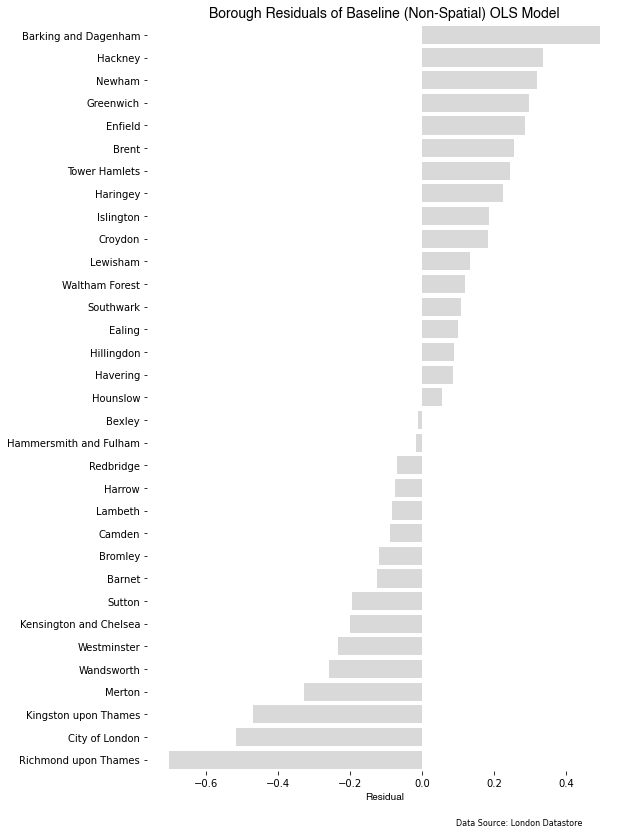

In [20]:
# Visualise the residuals by borough in a bar chart
fig = plt.figure(figsize=(8.5, 13.75))
ax = plt.gca()

sns.barplot(x="residual", # x-axis variable
            y="local_authority", # y-axis variable
            ax=ax, # Axes
            data=imd_2019.sort_values("residual", ascending = False), # Data, descendingly sorted by residual
            color="#d9d9d9") # Palette

font_title = {'family':'helvetica','color':'black','size':14} # Font title
plt.title('Borough Residuals of Baseline (Non-Spatial) OLS Model', fontdict=font_title)  # Chart title

font_axes = {'family':'helvetica','color':'black','size':10} # Axes font
plt.xlabel('Residuals',  fontdict = font_axes) # x-axis label
plt.ylabel('',  fontdict = font_axes) # y-axis label

plt.annotate('Data Source: London Datastore', (0,0), (308.75,-54.8), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotation of data source

ax.set_ylabel('') # Label for y-axis
ax.set_xlabel('Residual') # Label for x-axis

ax.set(frame_on=False) # Delete frame

plt.show()

<Figure size 432x288 with 0 Axes>

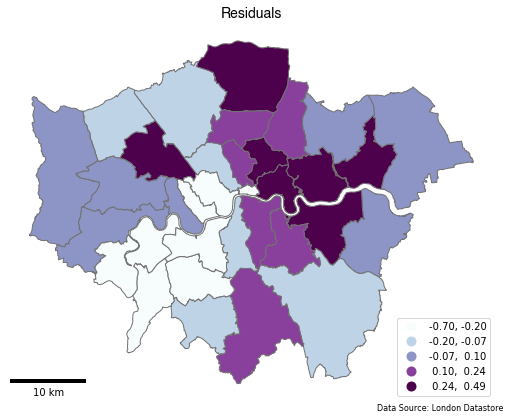

In [21]:
# Produce a choropleth map of the residuals in the boroughs
fig = plt.figure()
ax = imd_2019.plot(column="residual", # Variable by which to shade
                   figsize=(8.75, 8.75), # Figure size
                   scheme="Quantiles", # Classification scheme
                   cmap="BuPu", # Palette
                   edgecolor='#737373', # Line colour
                   legend=True, # Legend
                   legend_kwds={"loc": "lower right"}) # Legend location

font_title = {'family':'helvetica','color':'black','size':14} # Font title
plt.title('Residuals', fontdict=font_title) # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (370,-10), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotation of data source

ax.set_axis_off() # Delete axis

ax.add_artist(ScaleBar(1, location='lower left')) # Scale bar

plt.show()

#### Spatially Lagged Exogenous Regressors
In order to introduce space into the regression models, we can lag an independent variable. To do so, we will add another independent variable (i.e. the health deprivation and disability average score) and then assign a spatial lag based on this variable. We can express this equation as:

$$
ln(Y_i) = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i
$$

in which $Y_i$ is the dependent variable (i.e. logarithmic IMD average score), $X'_i$ is a subset of $X_i$ (i.e. the independent variables), and $w_{ij}$ is the $ij$-th cell of a spatial weights matrix $W$. Since $W$ assigns non-zero values to nearby boroughs, if $W$ is row-standardized, then $\sum_j w_{ij} X'_i$ calculates the average value of $X'_i$ in surrounding $i$ boroughs. This is called the *spatial lag* of $X_i$.

In [22]:
# Produce the spatial weights matrix
w_health_dep_disability_avg_score = weights.KNN.from_dataframe(imd_2019, k=6)

In [23]:
# Assign spatial lag based on the health deprivation and disability average score
lagged = imd_2019.assign(w_health_dep_disability_avg_score=weights.spatial_lag.lag_spatial(w_health_dep_disability_avg_score, imd_2019['health_dep_disability_avg_score'].values))

In [24]:
# Add the lagged health deprivation and disability average score variable to the other independent variables
independent_vars = ['living_env_avg_score', 'health_dep_disability_avg_score']
extended_vars = independent_vars + ["w_health_dep_disability_avg_score"]
extended_vars_n = ['living_env_score', 'health_dep_dis_score', 'w_health_dep_dis_score']

In [25]:
# Produce the spatial model with the lagged independent variable
ols_w = spreg.OLS(lagged[['log_imd_avg_score']].values, # Dependent variable
                   lagged[extended_vars].values, # Independent variables
                   w=W, # Spatial weights matrix
                   name_y=y_n, # Name of dependent variable
                   name_x=extended_vars_n) # Name of independent variable

print(ols_w.summary) # Print a summary of the model

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_imd_score                Number of Observations:          33
Mean dependent var  :      3.0152                Number of Variables   :           4
S.D. dependent var  :      0.3071                Degrees of Freedom    :          29
R-squared           :      0.7306
Adjusted R-squared  :      0.7027
Sum squared residual:       0.813                F-statistic           :     26.2149
Sigma-square        :       0.028                Prob(F-statistic)     :   2.099e-08
S.E. of regression  :       0.167                Log likelihood        :      14.281
Sigma-square ML     :       0.025                Akaike info criterion :     -20.562
S.E of regression ML:      0.1570                Schwarz criterion     :     -14.576

----------------------------------------------------------------------------

In [26]:
# Produce a dataset containing the coefficient, standard error and p-value from the model
ols_w_vals = pandas.DataFrame({"Coefficient": ols_w.betas.flatten(), # Coefficient
                                "Standard Error": ols_w.std_err.flatten(), # Standard error
                                "P-Value": [i[1] for i in ols_w.t_stat], # P-Value
                              },index=ols_w.name_x) # Index of independent variables

print(ols_w_vals) # Print

                        Coefficient  Standard Error       P-Value
CONSTANT                   2.923716        0.149658  3.098730e-18
living_env_score           0.010257        0.004400  2.689855e-02
health_dep_dis_score       0.481654        0.071102  1.952487e-07
w_health_dep_dis_score     0.010018        0.023595  6.742835e-01


#### Spatially Lagged Endogenous Regressors
A spatial lag model adds a lag to the dependent variable (i.e. $ln(Y_i)$ or the logarithmic IMD average score). Since $ln(Y_i)$ is lagged, it is not an OLS model. We can express this equation as:

$$
ln(Y_i) = \alpha + \lambda \sum_j w_{ij} ln(Y_i) + \beta X_i + \epsilon_i
$$

In [27]:
# Specify the independent variables and the names of the independent variables
independent_vars = ['living_env_avg_score', 'health_dep_disability_avg_score']
independent_vars_n = ['living_env_score', 'health_dep_dis_score']

In [28]:
# Produce the spatial model with the lagged dependent variable
lag = spreg.GM_Lag(imd_2019[['log_imd_avg_score']].values, # Dependent variable
                   imd_2019[independent_vars].values, # Independent variables
                   w=W, # Spatial weights matrix
                   name_y=y_n, # Name of dependent variable
                   name_x=independent_vars_n) # Name of independent variables

print(lag.summary) # Print a summary of the model

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_imd_score                Number of Observations:          33
Mean dependent var  :      3.0152                Number of Variables   :           4
S.D. dependent var  :      0.3071                Degrees of Freedom    :          29
Pseudo R-squared    :      0.7398
Spatial Pseudo R-squared:  0.7292

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       2.6855386       0.6780307       3.9607920       0.0000747
    living_env_score       0.0101373       0.0040496       2.5032709       0.0123051
health_dep_dis_score       0.4832628       0.0663050      

#### Prediction Performance
In order to compare the prediction performance of the models, we can use the [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error), a standard metric of accuracy in machine learning. The MSE calculates the average squared difference between the estimated values and the actual value. The MSE can be utilised to evaluate whether the spatial models are an improvement on the non-spatial model. To summarise, the higher the MSE, the higher the error and the worse the model performed.

In [29]:
# Calculate the Mean Squared Error (MSE), or prediction performance, of the OLS models
mse_vals = pandas.Series({'ols': mse(y, ols.predy.flatten()), # ols model (non-spatial)
                          'ols_w': mse(y, ols_w.predy.flatten()), # ols model with spatially lagged independent variable (i.e. Spatially Lagged Exogenous Regressors)
                          'lag': mse(y, lag.predy.flatten())}) # spatial lag model with lagged dependent variable (i.e. Spatially Lagged Endogenous Regressors)

print(mse_vals.sort_values().to_string()) # Print by ascendingly sorted MSE

lag      0.023800
ols_w    0.024640
ols      0.069417


By including the surrounding health deprivation and disability scores (i.e. ols_w), we have reduced the MSE of the non-spatial model (i.e. ols). The inclusion of the spatial lag of the IMD score (i.e. lag) also improves the accuracy of the non-spatial model.

### Unsupervised Machine Learning
In unsupervised machine learning, unlabeled datasets are utilised to identify patterns. In this example we will be drawing on [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), an unsupervised machine learning technique. It is important to note that there are a range of other [clustering algorithms](https://en.wikipedia.org/wiki/Cluster_analysis#Algorithms).

The aforementioned 2019 Indices of Multiple Deprivation (IMD) data on the [London Datastore](https://data.london.gov.uk/dataset/indices-of-deprivation) will be utilised to cluster boroughs in Greater London based on the living environment and health deprivation and disability average scores.

First, let's explore the IMD data and its spatial structure.

In [30]:
# Load the IMD 2019 dataset
imd_data = gpd.read_file("https://github.com/lbuk/UD_Intro_SDSML2022/blob/master/03_machine_learning/data/gl_boro_imd_2019.geojson?raw=true")

<Figure size 432x288 with 0 Axes>

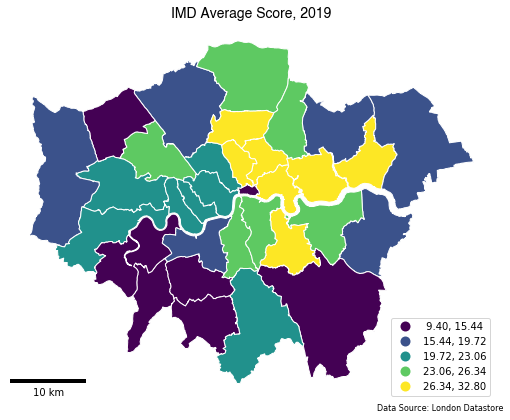

In [31]:
# Produce a choropleth map of the IMD average score in the boroughs
fig = plt.figure()
ax = imd_data.plot(column="imd_avg_score", # Variable by which to shade by
                   figsize=(8.75, 8.75), # Figure size
                   scheme="Quantiles", # Classification scheme
                   cmap="viridis", # Palette
                   edgecolor='#ffffff', # Line colour
                   legend=True, # Legend
                   legend_kwds={"loc": "lower right"}) # Location of legend

font_title = {'family':'helvetica','color':'black','size':14} # Font title
plt.title('IMD Average Score, 2019', fontdict=font_title)  # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (370,-10), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotation of data source

ax.set_axis_off() # Delete axis

ax.add_artist(ScaleBar(1, location='lower left')) # Scale bar

plt.show()

In order to test the extent to which each variable contains spatial structure, we can utilise [spatial autocorrelation](https://en.wikipedia.org/wiki/Spatial_analysis#Spatial_auto-correlation). [Moran’s I](https://en.wikipedia.org/wiki/Moran%27s_I) is a measure the overall spatial autocorrelation: a positive Moran's I indicates that similar values cluster while a negative Moran's I indicates that dissimilar values cluster.

In [32]:
np.random.seed(0)

# Produce spatial weights matrix
w = Queen.from_dataframe(imd_data)

# Set the cluster variables
cluster_variables = ["living_env_avg_score",  "health_dep_disability_avg_score"]

# Calculate the Moran's I for each variable
mi_results = [
    Moran(imd_data[variable], w) for variable in cluster_variables
]

mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]

In [33]:
# Produce a table of the Moran's I and p-values by variable
morans_i_pval = pandas.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")

print(morans_i_pval) # Print

                                 Moran's I  P-value
Variable                                           
living_env_avg_score              0.339195    0.005
health_dep_disability_avg_score   0.203408    0.037


The Moran's I values demonstrate positive spatial autocorrelation for all variables. This means that there is spatial structure and that it is likely the clusters have a non random spatial distribution.

#### K-Means Clustering
K-means is one of the most popular clustering techniques. The k-means algorithm groups data into a pre-specified number of clusters so that each observation is more similar to the mean of its cluster than it is to the mean of any other cluster.

Scaling the data ensures that it is normalised since distances are sensitive to the units of measurement and cluster solutions can change when you re-scale the data.

In [34]:
# Scale the dataset
imd_data_scaled = robust_scale(imd_data[cluster_variables])

In [35]:
# Specify 6 clusters in k-means. The right number of clusters is typically unknown in practice
kmeans = cluster.KMeans(n_clusters=6)

In [36]:
# Build the cluster model
kmeans_clusters = kmeans.fit(imd_data_scaled)

In [37]:
# Merge the cluster data with IMD dataset
imd_kmeans_clusters = imd_data.assign(Cluster=kmeans_clusters.labels_)

# Alter formatting so that none of the clusters are zero
imd_kmeans_clusters['Cluster'] = imd_kmeans_clusters['Cluster'] + 1

We can visualise the spatial distribution of the k-means clusters using a choropleth map.

<Figure size 432x288 with 0 Axes>

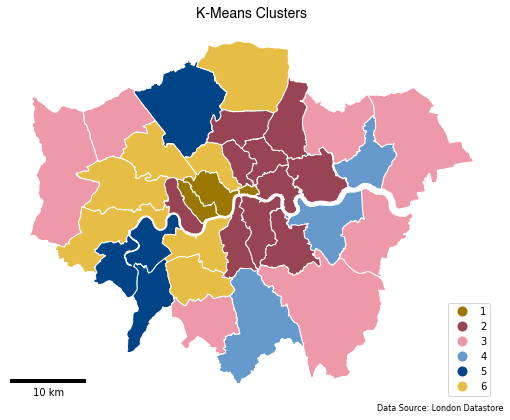

In [46]:
# Produce a choropleth map of the k-means clusters
# This map shows the spatial distribution of the k-means clusters
fig = plt.figure()
ax = imd_kmeans_clusters.plot(column='Cluster', # Variable by which to shade by
                              figsize=(8.75, 8.75), # Figure size
                              categorical=True, # Categorical data
                              edgecolor='#ffffff', # Line colour
                              cmap=ListedColormap(['#997700', '#994455', '#ee99aa', '#6699cc', '#004488', '#E6BE46']), # Qualitative palette
                              legend=True, # Legend
                              legend_kwds={"loc": "lower right"}) # Location of legend

font_title = {'family':'helvetica','color':'black','size':14} # Title font
plt.title('K-Means Clusters', fontdict=font_title) # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (370,-10), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotate data source

ax.set_axis_off() # Delete axis

ax.add_artist(ScaleBar(1, location='lower left')) # Scale bar

plt.show()

In [47]:
# Print summary data by cluster and average of the variables
imd_kmeans_clusters.groupby("Cluster")[cluster_variables].mean()

,living_env_avg_score,health_dep_disability_avg_score
Cluster,,
1,40.633333,-0.933333
2,35.770000,0.080000
3,20.100000,-0.671429
4,26.566667,0.000000
5,25.333333,-1.166667
6,30.271429,-0.457143


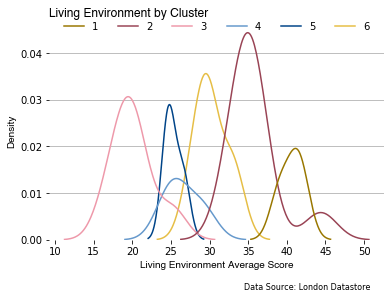

In [48]:
# Produce a KDE chart comparing the Living Environment Average Score densities for the clusters
fig = plt.figure()
ax = sns.kdeplot(imd_kmeans_clusters["living_env_avg_score"], # Living Environment Average Score
                 hue = imd_kmeans_clusters["Cluster"], # Colour by cluster
                 palette=['#997700', '#994455', '#ee99aa', '#6699cc', '#004488', '#E6BE46'], # Qualitative palette
                 legend=True, # Legend
                 shade=False) # Lines for KDE chart

sns.move_legend(ax, "center", bbox_to_anchor=(0.5, 0.98), ncol=6, title="", frameon=False) # Legend

font_axes = {'family':'helvetica','color':'black','size':10} # Axes font
plt.xlabel('Living Environment Average Score',  fontdict = font_axes) # x-axis label
plt.ylabel('Density',  fontdict = font_axes) # y-axis label

font_title = {'family':'helvetica','color':'black','size':12} # Title font
plt.title('Living Environment by Cluster', fontdict = font_title, loc = "left") # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (195,-50), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotate with data source

ax.set(frame_on=False) # Delete frame

ax.xaxis.grid(False) # Delete x-axis grid
ax.yaxis.grid(True) # Don't delete y-axis grid

plt.show()

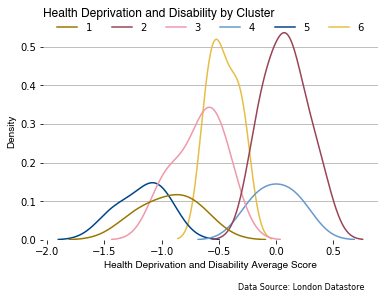

In [49]:
# Produce a KDE chart comparing the Health Deprivation and Disability Average Score densities for the clusters
fig = plt.figure()
ax = sns.kdeplot(imd_kmeans_clusters["health_dep_disability_avg_score"], # Health Deprivation and Disability Average Score
                 hue = imd_kmeans_clusters["Cluster"], # Colour by cluster
                 palette=['#997700', '#994455', '#ee99aa', '#6699cc', '#004488', '#E6BE46'], # Qualitative palette
                 legend=True, # Legend
                 shade=False) # Lines for KDE chart

sns.move_legend(ax, "center", bbox_to_anchor=(0.5, 0.978), ncol=6, title="", frameon=False) # Legend

font_axes = {'family':'helvetica','color':'black','size':10} # Axes font
plt.xlabel('Health Deprivation and Disability Average Score',  fontdict = font_axes) # x-axis label
plt.ylabel('Density',  fontdict = font_axes) # y-axis label

font_title = {'family':'helvetica','color':'black','size':12} # Title font
plt.title('Health Deprivation and Disability by Cluster', fontdict = font_title, loc = "left") # Chart title

plt.annotate('Data Source: London Datastore', (0,0), (195,-50), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points') # Annotate with data source

ax.set(frame_on=False) # Delete frame

ax.xaxis.grid(False) # Delete x-axis grid
ax.yaxis.grid(True) # Don't delete y-axis grid

plt.show()

#### Google Earth Engine
[Google Earth Engine](https://earthengine.google.com/): "is a cloud-based geospatial analysis platform that enables users to visualise and analyse satellite images of our planet". This example draws on unsupervised machine learning techniques - including k-means clustering - as well as satellite data to classify land use in Google Earth Engine utilising Python.

First, the features with numeric properties in which to find clusters are identified. Next, the clusterer is instantiated and the parameters are set. The clusterer is then trained utilising the training data. The clusterer is subsequently applied to a satellite image. Finally, the clusters are labelled in Google Earth Engine.

In [246]:
# conda create -n gee
# conda activate gee
# conda install mamba -c conda-forge
# mamba install geemap -c conda-forge

In [266]:
Map = geemap.Map()

In [267]:
# Generate point data
point = ee.Geometry.Point([-0.1276227, 51.5033725])

In [268]:
# Extract satellite data and filter
image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2019-01-01', '2019-12-31') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]')

In [269]:
# Set visualisation parameters
vis_params = {'min': 0,
              'max': 3000,
              'bands': ['B5', 'B4', 'B3']}

In [270]:
# Map
Map.centerObject(point, 8)
Map.addLayer(image, vis_params, "Landsat-8")
Map

Map(center=[51.503372500000005, -0.12762270000000003], controls=(WidgetControl(options=['position', 'transpare…

In [258]:
# Derive properties from the data
props = geemap.image_props(image)

In [259]:
# Print the Landsat ID
props.get('LANDSAT_ID').getInfo()

'LC08_L1TP_202024_20190420_20190507_01_T1'

In [260]:
# Print the satellite source
props.get('SATELLITE').getInfo()

'LANDSAT_8'

In [261]:
# Print the cloud cover
props.get('CLOUD_COVER').getInfo()

0.09

In [262]:
# Build a training dataset and add it to the map
training = image.sample(**{'scale': 30,
                           'numPixels': 5000,
                           'seed': 0,
                           'geometries': True})

In [263]:
# Map
Map.addLayer(training, {}, 'training', False)
Map

Map(bottom=22094.0, center=[51.503372500000005, -0.12762270000000003], controls=(WidgetControl(options=['posit…

In [264]:
# Instantiate the clusterer
n_clusters = 6 # Number of clusters
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training) # Build a k-means cluster model with the training data

In [ ]:
# Cluster the input using the trained clusterer
result = image.cluster(clusterer)

In [265]:
# Map the clusters
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(bottom=22094.0, center=[51.503372500000005, -0.12762270000000003], controls=(WidgetControl(options=['posit…

In [ ]:
# Produce and export a tif file of the clusters
geemap.ee_export_image(result, filename='cluster.tif', scale=75)

### Exercises
1. Build an OLS (non-spatial) regression model with the logarithmic imd average score as the dependent variable and the health deprivation and disability average score as the independent variable and print a summary of the results.
2. Using IMD dataset and k-means, cluster the boroughs based on the IMD average score, the living environment average score and the health deprivation and disability average score and produce a choropleth map of the clusters.

### Resources
- [Programming Collective Intelligence](https://www.oreilly.com/library/view/programming-collective-intelligence/9780596529321/)
- [Geographic Data Science with Python](https://geographicdata.science/book/intro.html)
- [Geographic Data Science with PySAL and the pydata stack](http://darribas.org/gds_scipy16/)
- [Introduction to Python for Geographic Data Analysis](https://pythongis.org/#)
- [Geoprocessing with Python](https://livebook.manning.com/book/geoprocessing-with-python)
- [Python Foundation for Spatial Analysis](https://courses.spatialthoughts.com/python-foundation.html)
- [Ethical Considerations in Machine Learning for Research and Statistics](https://uksa.statisticsauthority.gov.uk/publication/ethical-considerations-in-the-use-of-machine-learning-for-research-and-statistics/)
- [Machine Learning and the City - Applications in Architecture and Urban Design](https://www.wiley.com/en-gb/Machine+Learning+and+the+City:+Applications+in+Architecture+and+Urban+Design-p-9781119749639)

#### Note
Code and text from this lab was partly sourced from Daniel Arribas-Bel's tutorials on [Spatial Regression](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) and [Spatial Clustering](http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html), which are licensed according to Creative Commons BY-NC-SA, as well as [Chapter 10](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html) and [Chapter 11](https://geographicdata.science/book/notebooks/11_regression.html) of the open source [Geographic Data Science with Python](https://geographicdata.science/book/) book by Sergio J. Rey, Daniel Arribas-Bel and Levi J. Wolf, which is licensed according to Creative Commons BY-NC-SA. Code and text was also source from a tutorial from the [Geospatial Data Science blog](https://blog.gishub.org/earth-engine-tutorial-31-machine-learning-with-earth-engine-unsupervised-classification) and [geemap](https://github.com/giswqs/geemap) notebooks, which is licenced according to the MIT license.